In [20]:
import os, sys
import numpy as np
from astropy.constants import m_e
from astropy.coordinates import Distance
import astropy.units as u
import matplotlib.pyplot as plt
from IPython.display import Image


#### AGNpy classes ####
from agnpy.spectra import PowerLaw
from agnpy.emission_regions import Blob
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
from agnpy.utils.plot import plot_sed, load_mpl_rc

load_mpl_rc()

### Emission Region

The first step is to define the relevant parameters for the emission region.
We consider it as a spherical region in the AGN jet, with radius $R_b = 10^{16}$ cm, filled with plasma streaming with Lorentz factor $\Gamma = 10$.
Since we're defining a Blazar-like source, we can assume that the jet is almost aligned to the line of sight, and the Doppler boosting will also be $\delta_D = 10$.
We consider a magnetic field in the region of $B = 1 G$.
Consider the region to be at a luminosity distance $d_L = 10^{27}$ cm.

Finally, we consider the electron distribution to be described by a power law of index 
$p \sim 2.8$ and total energy content of $W_{e} = 10^{48}$

We define the emission region through the Blob method that defines a simple spherical emission region.
The input parameters for the definition, in the comoving frame are:
 - R_b: Radius of the region
 - z: redshift of the source
 - delta_D: Doppler factor of the relativistic factor
 - Gamma: Lorentz factor of the relativistic outflow
 - B: Magnetic field in the region in Gauss
 - n_e: Electron distribution in the region
 - n_p: Proton distribution in the blob
 - xi: acceleration coeffiecient for first-order Fermi acceleration
 - gamma_e_size: size of the array of electron Lorentz factors
 - gamma_p_size: size of the array of proton Lorentz factors
 - cosmology: cosmology to convert between distance and redshift (from astropy.cosmology)

In [21]:
# Emission Region Parameters:
R_b = 1e16 * u.cm                    
V_b = 4/3 * np.pi * np.power(R_b, 3) 
z = Distance(1e27, unit = u.cm).z    
delta_D = 10                         
Gamma = 10                           
B = 1 * u.G                         

agnpy.spectra.PowerLaw:
defines the relativistic electron distribution as a Power Law between given 
minimum and maximum Lorentz factors as:

$ n(\gamma') = k \gamma'^{-p} H(\gamma'; \gamma'_{min}, \gamma'_{max})$

where H is a Heaviside-like function ($H = 1$ in $[\gamma_{min}, \gamma_{max}]$ and  $H=0$ otherwise)

The from_total_energy method allows us to compute the normalization $k$ of the electron distribution from
the total energy in particles:

$ W = mc^2 \int \gamma n(\gamma) d\gamma $

and the volume $V$ of the emission region

In [22]:
# Electron distribution
W_e = 1e48 * u.Unit('erg')

n_e = PowerLaw.from_total_energy(W = W_e, V = V_b, p = 2.8,
                                 gamma_min = 1e2, gamma_max = 1e5, mass = m_e)

# Define the emission region
blob = Blob(R_b, z, delta_D, Gamma, B, n_e = n_e)

### Synchrotron Radiation

We first compute the hump coming from synchrotron radiation, using the parameters
defined above. We can also include the effects of Synchrotron Self-Absorption on the SED.

The computation of the SED is performed through Eq. 21 from Finke et al. (2008):

$f_{e}^{Syn} = \frac{\sqrt{3} \delta_D^4 \epsilon' e^3 B}{4 \pi h d_L^2} \int_1^\infty d\gamma' N'_e(\gamma')R(x)$

where R(x) is a function of $x = \frac{4 \pi \epsilon' m_e^2 c^3}{3 e B h \gamma'^2}$ defined by Crusius \& Schlickeiser (1986) to compute the synchrotron emissivity from isotropic electrons in a randomly oriented magnetic field.

If SSA is set to True, includes the effects of Synchrotron Self Absorption to the computation, computing the optical depth for self absorption $\tau_{SSA}$ and multiplying the SED for the corresponding attenuation factor $e^{-\tau_{SSA}}$

The optical depth for the SSA is computed as:

$\tau_{SSA} = - \frac{1}{8 \pi m_e \epsilon^2 \left(\lambda_{C,e}/c\right)^3} \int d\gamma'  \frac{d\tau}{d\gamma'} P(\gamma') $

where the integrand is computed as:

$ \frac{d\tau}{d\gamma'} = \gamma'^2 \frac{d}{d\gamma'} \left(\frac{n_e(\gamma')}{\gamma'^2}\right)$

multiplied by the single particle synchrotron power:

$P(\gamma') = \frac{\sqrt{3} e^3 B}{h} R(x)$






In [23]:
# these define a class that allows us to compute the SED at given frequencies
synch = Synchrotron(blob)
synch_ssa = Synchrotron(blob, ssa = True)

In [34]:
# Define a list of frequencies for the computation:
nu_syn = np.logspace(8, 23) * u.Hz

# Compute Synchrotron and SSA SEDs
synch_sed = synch.sed_flux(nu_syn)
synch_sed_ssa = synch_ssa.sed_flux(nu_syn)

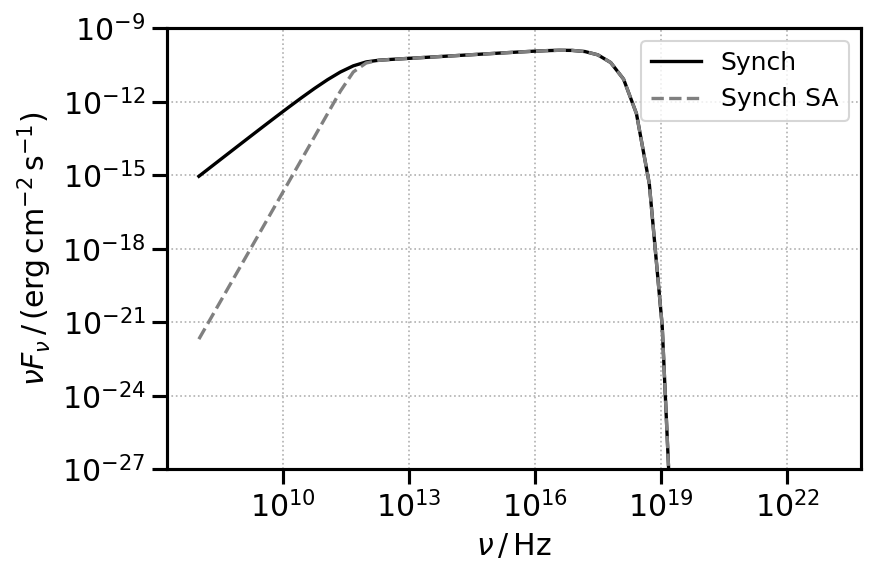

In [35]:
# Plot the results
fig, ax = plt.subplots(figsize = (6,4))
plot_sed(nu_syn, synch_sed, ax = ax, color = 'k', label = 'Synch')
plot_sed(nu_syn, synch_sed_ssa, ax = ax, ls = '--', color = 'gray', label = 'Synch SA')
ax.set_ylim(1e-27, 1e-9)
plt.show()

### Synchrotron Self-Compton Radiation

Similarly to the above, we define the second hump at higher frequencies.
The Synchrotron Self-Compton class is used to compute the SED.

In [36]:
# Simple SSC 
ssc = SynchrotronSelfCompton(blob)
# SSC over a SSA spectrum
ssc_ssa = SynchrotronSelfCompton(blob, ssa = True)

The energy density of radiation for the synchrotron spectrum, from eq. 8 in Finke et al. (2008):

$u'^{syn}(\epsilon') = \frac{3}{4} \epsilon' m_e c^2 n'_{syn}(\epsilon') = \frac{3}{4} \frac{3 d_L^2 (1+z)^2 f_\epsilon^{syn}}{c^3 t^2_{v,min} \delta_D^6 \epsilon'}$

with the addition of the 3/4 factor to account for the averaging over a sphere.

from which we can find the emissivity through Eq (9) in Finke et al. (2008):

$\epsilon'_s J'_{SSC}(\epsilon'_s) = \frac{3}{4} c \sigma_T {\epsilon'_{s}}^{2}$
$\int_0^\infty d\epsilon' \frac{u'(\epsilon')}{\epsilon'^2}$
$\int_{\gamma_{min}}^{\gamma_{max}} d\gamma' \frac{N'_e(\gamma')}{\gamma'^2} F_C(q,\Gamma_e)$

Where $\epsilon'_s$ is the scattered energy of the photon, $\sigma_T$ is the Thompson cross section, and $F_C$ is the Compton scattering kernel for isotropic distribution from Jones (1968).

From the emissivity, the spectrum is calculated, according to eq. (15) in Finke et al. (2008), as:

${f_{\epsilon_s}}^{SSC} = \frac{\delta_D^4 \epsilon'_s J'_{SSC}(\epsilon'_s)}{4 \pi d^2_Lf}$


In [37]:
nu_ssc = np.logspace(15, 30) * u.Hz
sed_ssc = ssc.sed_flux(nu_ssc)
sed_ssc_ssa = ssc_ssa.sed_flux(nu_ssc)

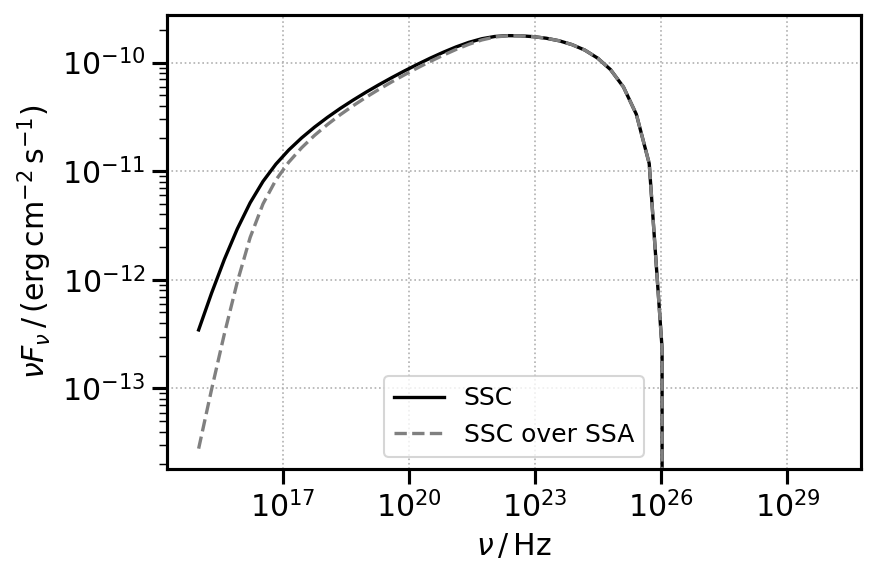

In [38]:
fig, ax = plt.subplots(figsize = (6, 4))
plot_sed(nu_ssc, sed_ssc, color = 'k', label = 'SSC');
plot_sed(nu_ssc, sed_ssc_ssa, color = 'gray', ls = '--', label = 'SSC over SSA');
plt.show()

Now that we have both the spectra we can combine them to have the spectrum of our model blazar

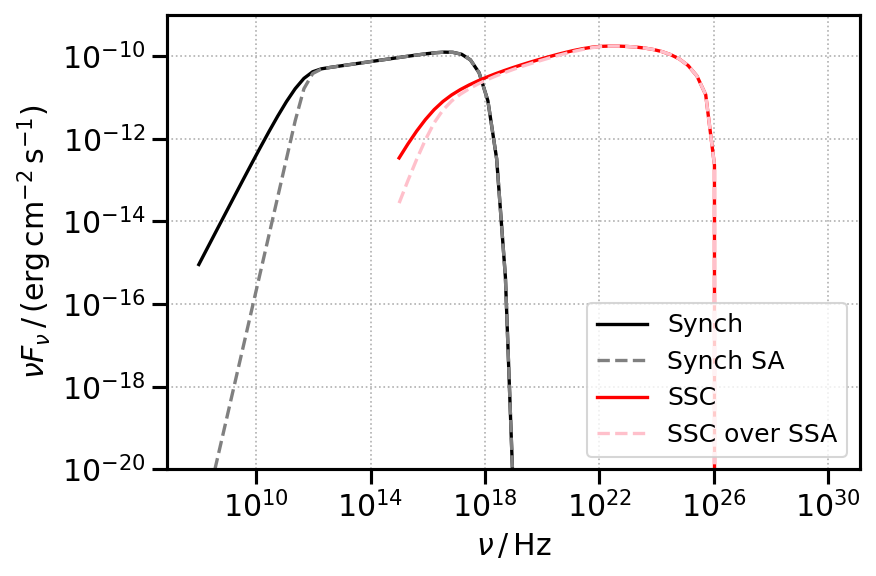

In [39]:
fig, ax = plt.subplots(figsize = (6,4))
plot_sed(nu_syn, synch_sed, ax = ax, color = 'k', label = 'Synch')
plot_sed(nu_syn, synch_sed_ssa, ax = ax, ls = '--', color = 'gray', label = 'Synch SA')


plot_sed(nu_ssc, sed_ssc, color = 'red', label = 'SSC');
plot_sed(nu_ssc, sed_ssc_ssa, color = 'pink', ls = '--', label = 'SSC over SSA');

ax.set_ylim(1e-20, 1e-9)
plt.show()

In [40]:
# Define a list of frequencies for the computation:
nu = np.logspace(8, 30) * u.Hz 

# Compute Synchrotron
synch_sed = synch.sed_flux(nu)
synch_sed_ssa = synch_ssa.sed_flux(nu)

# Compute SSC
sed_ssc = ssc.sed_flux(nu)
sed_ssc_ssa = ssc_ssa.sed_flux(nu)

# Compute the total SED
total_sed = synch_sed + sed_ssc
total_sed_ssa = synch_sed_ssa + sed_ssc_ssa



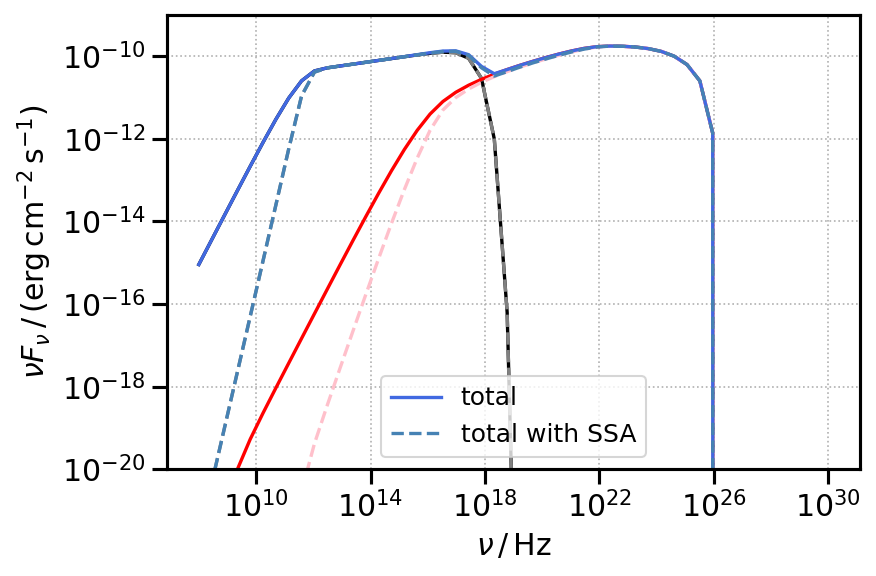

In [45]:
fig, ax = plt.subplots(figsize = (6,4))

plot_sed(nu, synch_sed, ax = ax, color = 'k');
plot_sed(nu, synch_sed_ssa, ax = ax, ls = '--', color = 'gray');

plot_sed(nu, sed_ssc, color = 'red');
plot_sed(nu, sed_ssc_ssa, color = 'pink', ls = '--');

plot_sed(nu, total_sed, color = 'royalblue', label = 'total')
plot_sed(nu, total_sed_ssa, color = 'steelblue', ls = '--', label = 'total with SSA')

ax.set_ylim(1e-20, 1e-9)
plt.show()